In [93]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Import Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image

# import cv2

import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Sample TensorFlow operation to verify installation
a = tf.constant([1.0, 2.0, 3.0])
b = tf.constant([4.0, 5.0, 6.0])
c = a + b
print("TensorFlow operation result:", c.numpy())


TensorFlow version: 2.17.0
TensorFlow operation result: [5. 7. 9.]


In [94]:
directory_train = '/Users/archanakale/Documents/GitHub/deep-learning-challenge/Project_4_covid19_detection/Data/Train'
directory_validation = '/Users/archanakale/Documents/GitHub/deep-learning-challenge/Project_4_covid19_detection/Data/Val'
directory_test = '/Users/archanakale/Documents/GitHub/deep-learning-challenge/Project_4_covid19_detection/Data/Prediction'

In [95]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    vertical_flip = True
)

In [96]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Update the directory path

directory_train = '/Users/archanakale/Documents/GitHub/deep-learning-challenge/Project_4_covid19_detection/Data/Train'

# Data augmentation and pre-processing using tensorflow
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    vertical_flip = True
)

train_generator = gen.flow_from_directory(
    directory = directory_train,
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)


Found 288 images belonging to 2 classes.


In [97]:
# Data augmentation and pre-processing using tensorflow
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    vertical_flip = True
)
validation_generator = gen.flow_from_directory(
    directory = directory_validation, # Use updated path
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 60 images belonging to 2 classes.


In [98]:
x, y = next(train_generator)
x.shape

(8, 331, 331, 3)

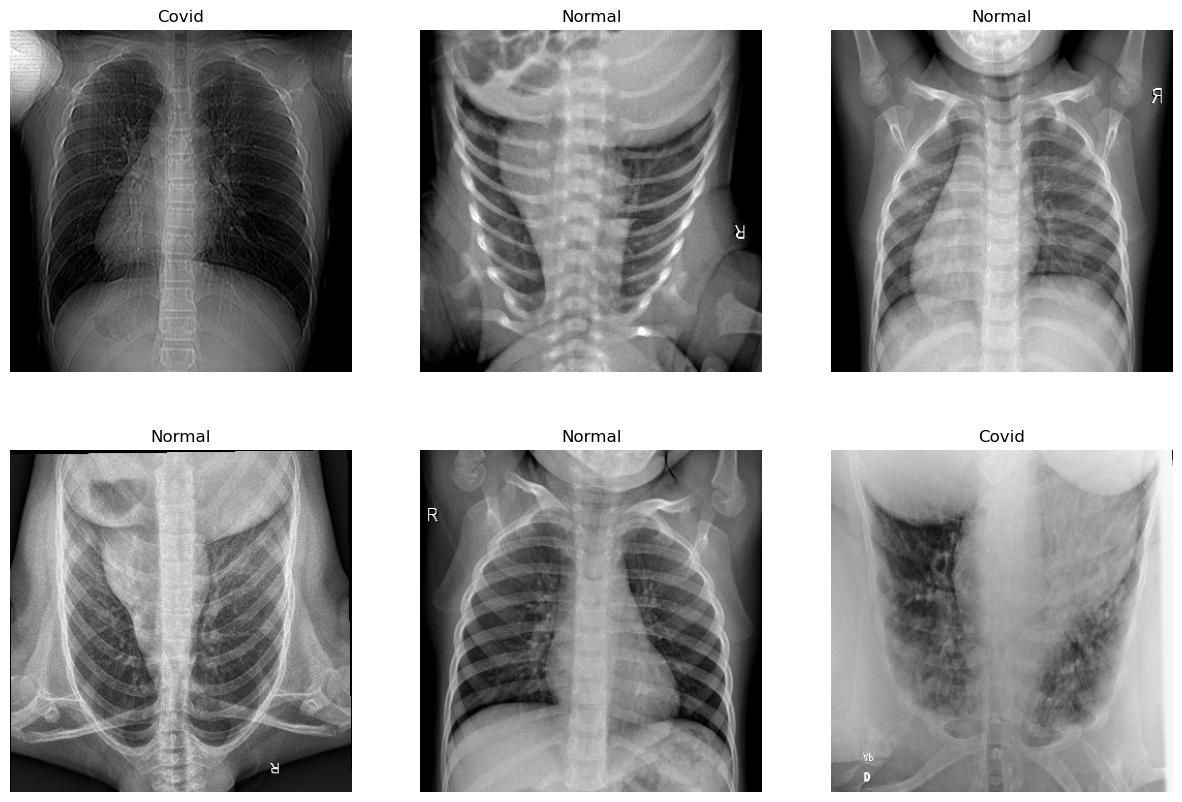

In [99]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

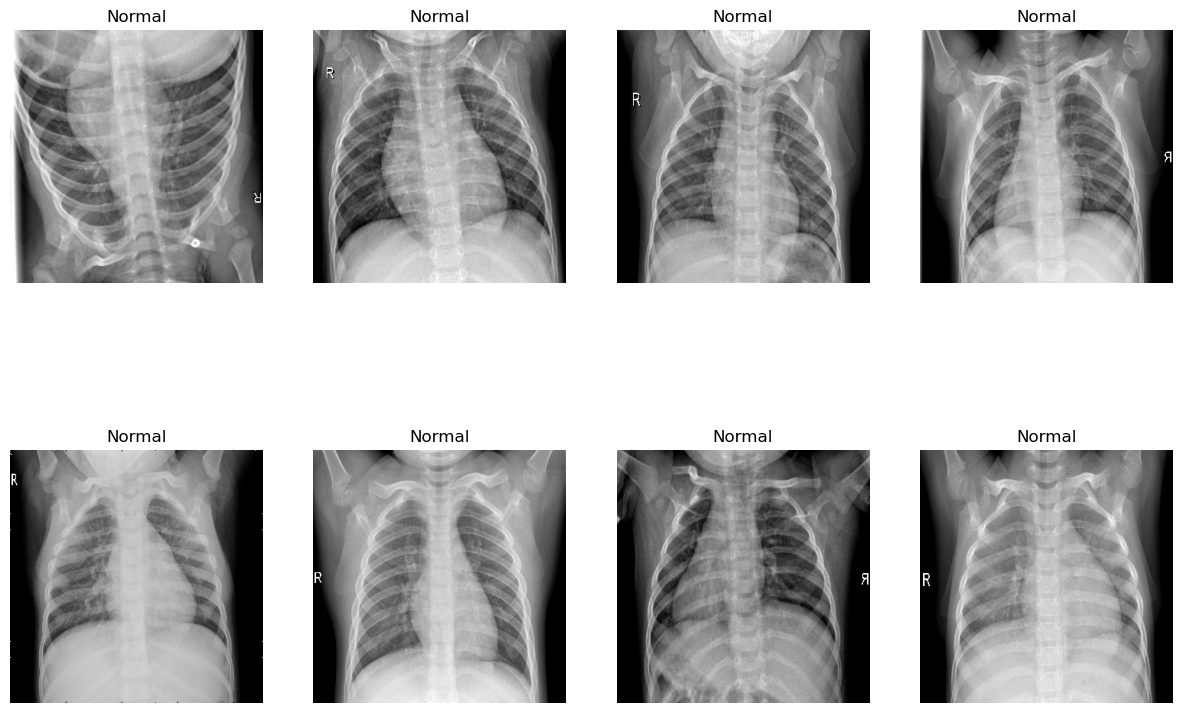

In [100]:
def extract_and_plot_normal_images(generator, num_images=8):
    """
    Extracts and plots normal images from a data generator.

    Args:
        generator: A data generator that yields batches of images and labels.
        num_images: The number of normal images to extract and plot.
    """
    normal_images = []
    normal_label = generator.class_indices['Normal']  # Get the index for 'Normal' class

    while len(normal_images) < num_images:
        images, labels = next(generator)
        for i in range(len(labels)):
            # Check if the label corresponds to 'Normal' class
            if np.argmax(labels[i]) == normal_label:
                normal_images.append(images[i])
                if len(normal_images) >= num_images:
                    break

    # Plot the extracted normal images
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(normal_images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(normal_images[i])
        plt.title('Normal')
        plt.axis('off')
    plt.show()

# Call the function to extract and plot 8 normal images
extract_and_plot_normal_images(train_generator)


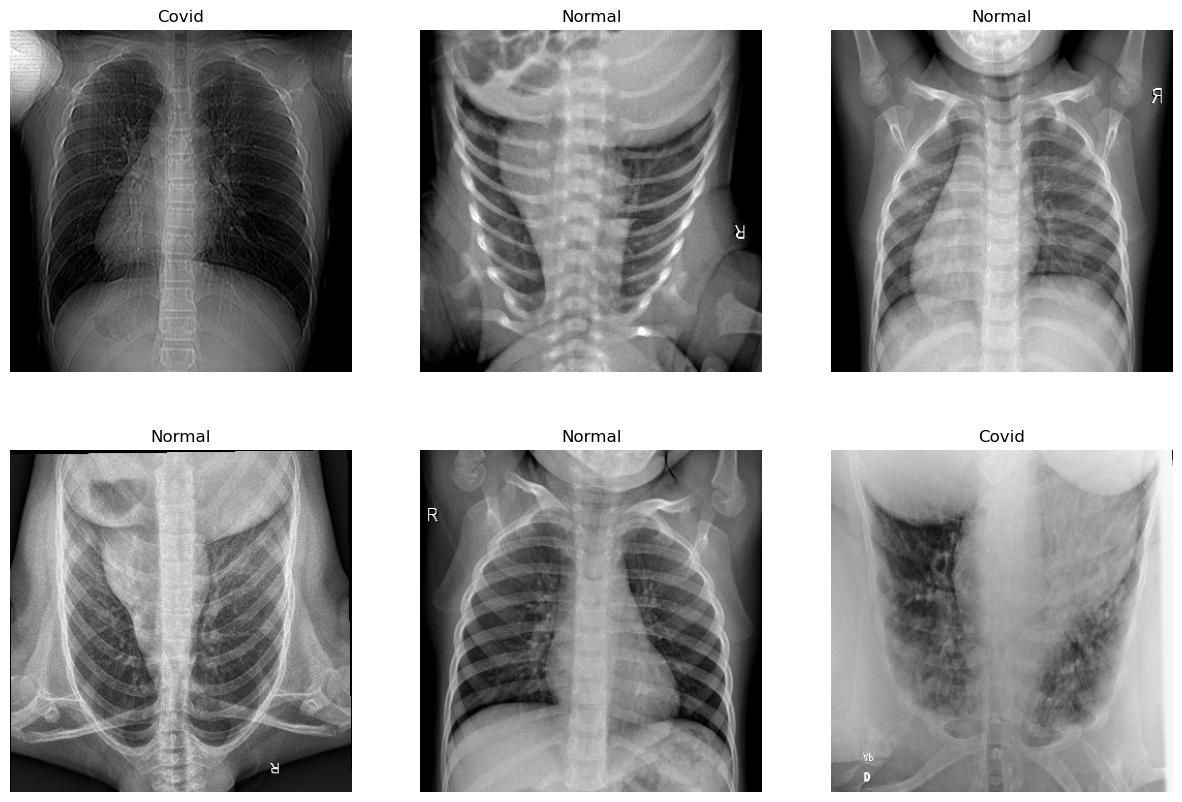

In [101]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

In [102]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(331,331,3)
)

base_model.trainable=False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(120, activation='softmax'),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [103]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [104]:
# Set the input shape
input_shape = (1, 331, 331, 3)

# Set the input shape for the base model
base_model.build(input_shape)

# Call model.summary()
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (1, 10, 10, 512)       │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [105]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (1, 10, 10, 512)       │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [106]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                         min_delta=0.001,
                                         restore_best_weights=True)

In [107]:
%pip install graphviz
%pip install pydotplus



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [108]:
%pip install graphviz
%pip install pydotplus --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [109]:
import pydot
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])



In [110]:
tf.keras.utils.plot_model


<function keras.src.utils.model_visualization.plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=200, show_layer_activations=False, show_trainable=False, **kwargs)>

In [112]:
!pip install torch
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 10.9 MB/s eta 0:00:0000:0100:01


In [113]:
print(torch.__version__)

2.4.0


In [114]:
# for reproducibility
torch.manual_seed(0)

In [115]:
!ls /

Applications Users        cores        home         sbin         var
Library      Volumes      dev          opt          tmp
System       bin          etc          private      usr


In [116]:
!ls /tmp

/tmp


In [117]:
!mkdir /tmp/Xray_train_data

In [127]:
!cp -R "/Users/archanakale/Documents/GitHub/deep-learning-challenge/Project_4_covid19_detection/Data/Val'

zsh:1: unmatched "


In [124]:
!cp -R "/Users/archanakale/Documents/GitHub/deep-learning-challenge/Project_4_covid19_detection/Data/Val'ata"

usage: cp [-R [-H | -L | -P]] [-fi | -n] [-aclpSsvXx] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-aclpSsvXx] source_file ... target_directory


In [128]:
!ls "/tmp/Xray_train_data"